In [16]:
from __future__ import print_function

import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [17]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [18]:
train_set = torchvision.datasets.CIFAR100('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR100('./datasets', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, 
                                          shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [19]:
classes = ('cattle',
'dinosaur',
'apple',
'boy',
'aquarium_fish',
'telephone',
'train',
'cup',
'cloud',
'elephant',
'keyboard',
'willow_tree',
'sunflower',
'castle',
'sea',
'bicycle',
'wolf',
'squirrel',
'shrew',
'pine_tree',
'rose',
'television',
'table',
'possum',
'oak_tree',
'leopard',
'maple_tree',
'rabbit',
'chimpanzee',
'clock',
'streetcar',
'cockroach',
'snake',
'lobster',
'mountain',
'palm_tree',
'skyscraper',
'tractor',
'shark',
'butterfly',
'bottle',
'bee',
'chair',
'woman',
'hamster',
'otter',
'seal',
'lion',
'mushroom',
'girl',
'sweet_pepper',
'forest',
'crocodile',
'orange',
'tulip',
'mouse',
'camel',
'caterpillar',
'man',
'skunk',
'kangaroo',
'raccoon',
'snail',
'rocket',
'whale',
'worm',
'turtle',
'beaver',
'plate',
'wardrobe',
'road',
'fox',
'flatfish',
'tiger',
'ray',
'dolphin',
'poppy',
'porcupine',
'lamp',
'crab',
'motorcycle',
'spider',
'tank',
'orchid',
'lizard',
'beetle',
'bridge',
'baby',
'lawn_mower',
'house',
'bus',
'couch',
'bowl',
'pear',
'bed',
'plain',
'trout',
'bear',
'pickup_truck',
'can')


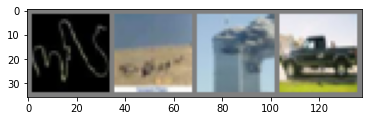

In [20]:
import matplotlib.pyplot as plt


def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [22]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [23]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))

            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [24]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

net = ResNet18().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)

    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [25]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [26]:
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [34]:
load_model = False
if load_model:
    checkpoint = torch.load('./res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

FileNotFoundError: [Errno 2] No such file or directory: './res18.ckpt'

In [28]:
def plot_loss(train_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
train_losses = []


for epoch in range(start_epoch, 50):
    loss = train(epoch)
    train_losses.append(loss)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss, epoch=epoch)


Epoch: 0
[1,   100] loss: 527.061901 |  Acc: 1.188% (19/1600)
[1,   200] loss: 987.491652 |  Acc: 1.406% (45/3200)
[1,   300] loss: 1444.397115 |  Acc: 1.438% (69/4800)
[1,   400] loss: 1897.663029 |  Acc: 1.578% (101/6400)
[1,   500] loss: 2345.315818 |  Acc: 1.738% (139/8000)
[1,   600] loss: 2786.090701 |  Acc: 1.948% (187/9600)
[1,   700] loss: 3220.802506 |  Acc: 2.304% (258/11200)
[1,   800] loss: 3651.520872 |  Acc: 2.414% (309/12800)
[1,   900] loss: 4077.015627 |  Acc: 2.611% (376/14400)
[1,  1000] loss: 4500.376219 |  Acc: 2.919% (467/16000)
[1,  1100] loss: 4919.791538 |  Acc: 3.125% (550/17600)
[1,  1200] loss: 5335.324148 |  Acc: 3.344% (642/19200)
[1,  1300] loss: 5747.680650 |  Acc: 3.514% (731/20800)
[1,  1400] loss: 6155.699896 |  Acc: 3.746% (839/22400)
[1,  1500] loss: 6566.865454 |  Acc: 3.967% (952/24000)
[1,  1600] loss: 6977.415144 |  Acc: 4.117% (1054/25600)
[1,  1700] loss: 7382.201861 |  Acc: 4.298% (1169/27200)
[1,  1800] loss: 7778.577249 |  Acc: 4.556% (13

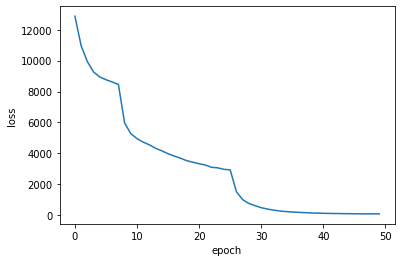

In [29]:
plot_loss(train_losses)

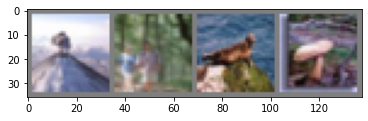

GroundTruth:   girl lobster flatfish forest
Predicted:  plate lobster aquarium_fish forest
Accuracy of the network on the 10000 test images: 61 %


In [30]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [31]:
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [32]:
for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cattle : 87 %
Accuracy of dinosaur : 81 %
Accuracy of apple : 50 %
Accuracy of   boy : 59 %
Accuracy of aquarium_fish : 52 %
Accuracy of telephone : 66 %
Accuracy of train : 57 %
Accuracy of   cup : 50 %
Accuracy of cloud : 80 %
Accuracy of elephant : 73 %
Accuracy of keyboard : 62 %
Accuracy of willow_tree : 42 %
Accuracy of sunflower : 71 %
Accuracy of castle : 38 %
Accuracy of   sea : 62 %
Accuracy of bicycle : 64 %
Accuracy of  wolf : 56 %
Accuracy of squirrel : 80 %
Accuracy of shrew : 60 %
Accuracy of pine_tree : 50 %
Accuracy of  rose : 87 %
Accuracy of television : 83 %
Accuracy of table : 63 %
Accuracy of possum : 73 %
Accuracy of oak_tree : 84 %
Accuracy of leopard : 59 %
Accuracy of maple_tree : 54 %
Accuracy of rabbit : 37 %
Accuracy of chimpanzee : 60 %
Accuracy of clock : 57 %
Accuracy of streetcar : 50 %
Accuracy of cockroach : 55 %
Accuracy of snake : 56 %
Accuracy of lobster : 66 %
Accuracy of mountain : 75 %
Accuracy of palm_tree : 37 %
Accuracy of skyscra

In [35]:
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/res18.ckpt')